# Tensor Flow Text Classification using BERT

This code started off as the tutorial from Tensor Flow. [TF BERT](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

I have made modifications to allow my datasets, ability to switch between datasets and optimizers,
created my own code for splitting the datasets into training, validation and testing, batched the datasets, and updated the original model.

In [19]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

## Choosing the Dataset

1. Set `tickerSymbol` to a stock ticker from the list below. 
2. Set `textChoice` to 'title' or 'content'. Chooses whether to use the just the 'title' or entire 'content' from the news article. 

The datasets were created by filtering out a selected stock from this news archive dataset: 
[Kaggle - US Equities News Data](https://www.kaggle.com/datasets/gennadiyr/us-equities-news-data?resource=download)

Then the historical price dataset for the stock was downloaded from: 
[Nasdaq - Historical Data](https://www.nasdaq.com/market-activity/quotes/historical)

The 2 datasets were merged and cleaned up to contain only what was needed. The datasets contain the 
date (which was used for merging), the news article title or content, and a label indicating that the daily
price increased (1) (or statyed the same) or decreased (0). 

In [20]:
# Choose a stock
# 'AAPL' 'MSFT' 'AMZN' 'TSLA' 'NFLX' 'GOOGL' 'BA'  
# 'Reddit' can also be used for the Reddit dataset. Note: only the title option can be used. 
tickerSymbol = 'Reddit'
textChoice = 'title' # 'title' 'content'

dataFile = '../Data/' + tickerSymbol + '_' + textChoice + '_' + 'NewsDataset.csv'

Change the `SHUFFLE_SEED` to re-shuffle the dataset prior to running. 

The seed allows reproducibility to repeat a run.

In [21]:
# Change this seed for a different shuffle. 
# Seed is here to create reproducible results, if needed. 
SHUFFLE_SEED = 12345

stockDF = pd.read_csv(dataFile)
stockDF = stockDF.sample(frac=1, random_state=SHUFFLE_SEED)

`BATCH_SIZE`, `TRAIN_PERCENT`, and `VALID_PERCENT` can be adjusted here.

1. `BATCH_SIZE` is the number of text features per batch
2. `TRAIN_PERCENT` is the percent of the dataset that is used for training vs. testing.
3. `VALID_PERCENT` is the percent of the training dataset that is used for validation.

In [22]:
N = len(stockDF)
BATCH_SIZE = 32
TRAIN_PERCENT = 0.8
VALID_PERCENT = 0.2

trainSize = int(N * TRAIN_PERCENT)
validSize = int(trainSize * VALID_PERCENT)

train_df = stockDF.iloc[:trainSize-validSize]
valid_df = stockDF.iloc[trainSize-validSize:trainSize]
test_df  = stockDF.iloc[trainSize: N]

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Text'],train_df['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['Text'],valid_df['Label']))
test_ds  = tf.data.Dataset.from_tensor_slices((test_df['Text'],test_df['Label']))

train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds  = test_ds.batch(BATCH_SIZE)

## Select Initial BERT Model

1. `bert_model_name` chooses which pretrained BERT model to start with. Use the dict below.

In [24]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [25]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [26]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## Build the Model

Below is the model definition. 

1. `L2_REGULARIZATION` can be adjusted to reduce the weights of the model to make a more generic model and avoid over fitting.

In [27]:
L2_REGULARIZATION = 0.000001    # Default = 0.01

In [28]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))(net)
  return tf.keras.Model(text_input, net)

In [29]:
classifier_model = build_classifier_model()

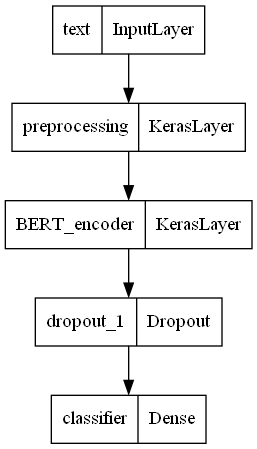

In [30]:
tf.keras.utils.plot_model(classifier_model)

In [31]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

## Choose Optimizer

1. Set `OPTIMIZER' to select a different optimizer for the model

In [32]:
epochs = 3
epsilson = 1e-3
init_lr = 3e-3
OPTIMIZER = 'Adam' 

optimizer = {
    'Adam'      : tf.optimizers.Adam(learning_rate=init_lr, epsilon=epsilson),
    'Adadelta'  : tf.optimizers.Adadelta(),
    'SGD'       : tf.optimizers.SGD()
}


In [33]:
classifier_model.compile(optimizer=optimizer[OPTIMIZER],
                         loss=loss,
                         metrics=metrics)

## Training the Model

Uses a combination of the pre-trained BERT model and the new input text to tune the model.

In [34]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=valid_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/3
40/40 [==============================] - 9s 191ms/step - loss: 0.7573 - binary_accuracy: 0.5035 - val_loss: 0.7065 - val_binary_accuracy: 0.4371
Epoch 2/3
40/40 [==============================] - 7s 186ms/step - loss: 0.7320 - binary_accuracy: 0.4737 - val_loss: 0.7220 - val_binary_accuracy: 0.4371
Epoch 3/3
40/40 [==============================] - 7s 186ms/step - loss: 0.7243 - binary_accuracy: 0.4713 - val_loss: 0.7273 - val_binary_accuracy: 0.4371


## Results

Testing the test dataset.

In [35]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 1s 53ms/step - loss: 0.7140 - binary_accuracy: 0.4774
Loss: 0.7140241265296936
Accuracy: 0.4773869216442108


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


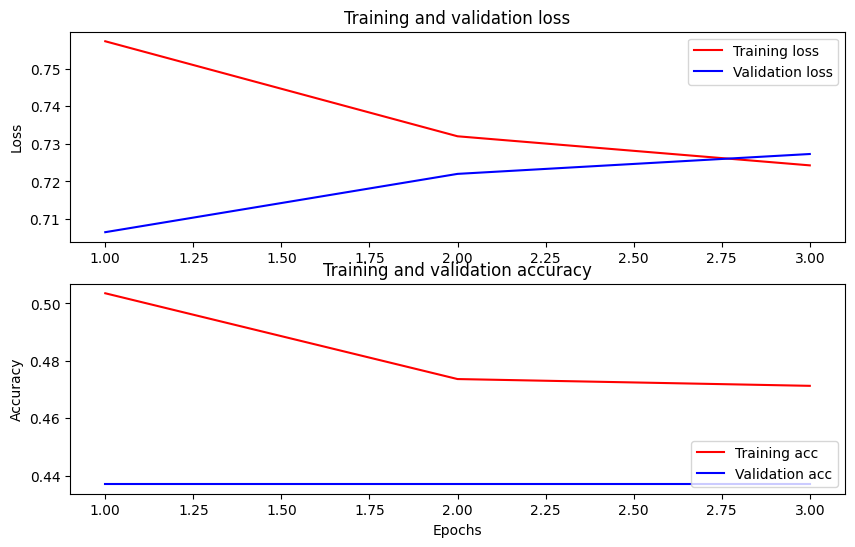

In [36]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [37]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'stock markets are failing',  # this is the same sentence tried earlier
    'world hunger is solved',
    'world war iii starts',
    'interest rates are falling',
    'does democracy work'
]

#reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

#print('Results from the saved model:')
#print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: stock markets are failing      : score: 0.415969
input: world hunger is solved         : score: 0.416632
input: world war iii starts           : score: 0.420439
input: interest rates are falling     : score: 0.417619
input: does democracy work            : score: 0.416009

